In [41]:
########################################
#LIBRARIES
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as d
import matplotlib.pyplot as plt
import json
import os
import time

########################################
#PARAMETERS
time_length = 60 #seconds
number_of_samples_test = 200
number_of_samples_train = 20
epochs = 20
minibatch_size= 5
hiddenlayers = [100]
input_size = 3
output_size = 3*time_length
learning_rate = 0.01
LRdecay = 0.7
model_file_path = 'Trained_Models/'
data_file_path = 'Data/Samples/data_20k_2x2x2/'

#######################################
# LOAD SIMULATION
dyn = d.PyDyn('Data/point-mass_pendulum.sim', time_length)
#dyn = d.PyDyn('Data/rb-pendulum/twoRb.sim', time_length)
state_init = dyn.compute(dyn.p_init)
f = dyn.f(state_init, dyn.p_init)
df = dyn.df_dp(state_init, dyn.p_init)
dy = dyn.dy_dp(state_init, dyn.p_init)

##########################################
#SAMPLE TARGETS
y_target = np.zeros((number_of_samples_train,3))
y_target[:,2] = np.random.rand(number_of_samples_train)*2
y_target[:,1] = np.random.rand(number_of_samples_train)*2
y_target[:,0] = np.random.rand(number_of_samples_train)*2
y_target= torch.tensor(y_target).float()
p_start = torch.zeros((minibatch_size, 3)).float()
for i in range(minibatch_size):
    p_start[i, :] = torch.tensor(dyn.p_init[0:3])

tensor([[1.7984, 0.0251, 0.6884],
        [0.2390, 1.2049, 0.8118],
        [1.3699, 1.5125, 0.9314],
        [0.8146, 0.3099, 0.3582],
        [1.2559, 1.6224, 0.1124],
        [0.4329, 0.7608, 0.8848],
        [0.9899, 1.2602, 1.1894],
        [1.9900, 0.2832, 1.6899],
        [0.2803, 1.8580, 0.7557],
        [1.9378, 0.4745, 1.6475],
        [1.0311, 0.3829, 0.5521],
        [0.0771, 1.6182, 0.3225],
        [1.3984, 1.5844, 1.1026],
        [1.2981, 0.5617, 0.6232],
        [0.3687, 0.8925, 1.1271],
        [1.9229, 1.2737, 0.9073],
        [0.0626, 0.0366, 0.5987],
        [1.5433, 1.3021, 0.3773],
        [0.8523, 1.8593, 0.5168],
        [0.9795, 0.6213, 0.4758]])

In [20]:
##########################################
#BUILD CUSTOM SIMULATION FUNCTION
class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        #print(f'input: {input.shape}')
        p = input.clone().numpy().transpose()
        y_pred = torch.ones([len(p[0, :]),3])
        for i in range(len(p[0, :])):
            state = dyn.compute(p[:,i])
            y_pred[i, :] = torch.tensor(state.y[-3:])
        #print(f'y_pred: {y_pred.shape}')
        
        ctx.save_for_backward(input)
        
        return y_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, = ctx.saved_tensors
        p = input.clone().numpy().transpose()
        dy_dp_batch = torch.zeros([3, 3*time_length])
        for i in range(len(p[0, :])):
            state = dyn.compute(p[:, i])
            dy_dp = dyn.dy_dp(state, p[:, i])
            dy_dp = torch.tensor(dy_dp[-3:, :])
            dy_dp_batch = dy_dp_batch + dy_dp
        #print(f'dy/dp_batch: {dy_dp_batch/samplenum}')
        
        grad_input = torch.tensor(grad_output.mm(dy_dp_batch.float()/len(p[0,:])))
        #print(f'shape of grad input: {grad_input.shape}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input

Simulate = Simulate.apply

########################################
#BUILD CUSTOM MODEL
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*time_length)
        self.L_out = nn.Linear(3*time_length, 3*time_length)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = ActiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)

####################################################
#TRAIN THE MODEL
torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 2 # basic error
weight_c2 = 1 # p start condition
weight_c3 = 1 # p smoothness condition
batch = np.floor(number_of_samples_train/minibatch_size).astype(int)
losses= []
smoothness_errors = []
p_start_errors = []
y_end_errors = [] #y_end error
for e in range(epochs):
    for b in range(batch):
        y_b = y_target[b*minibatch_size:b*minibatch_size+minibatch_size,:].float()
        p_b = model(y_b)
        y_pred = Simulate(p_b)
        #smoothness_error_i = weight_c3*(p_i[0:3*(time_length-1)] - p_i[3:3*time_length]).pow(2).sum()
        smoothness_error = weight_c3*criterion(p_b[:, 0:3*(time_length-1)], p_b[:, 3:3*time_length])
        #p_start_error = weight_c2*torch.sqrt(criterion(p_i[0:3], torch.tensor(dyn.p_init[0:3])))
        p_start_error = weight_c2*criterion(p_b[:, 0:3], p_start)
        #y_end_error = torch.sqrt(criterion(y_pred.float(), y_i))
        y_end_error = weight_c1*criterion(y_pred, y_b)
        loss = y_end_error + p_start_error + smoothness_error
        #loss = loss_batch/minibatch_size
        losses.append(loss)
        #smoothness_error = smoothness_error_batch/minibatch_size
        smoothness_errors.append(smoothness_error)
        y_end_errors.append(y_end_error)
        p_start_errors.append(p_start_error)
        optimizer.zero_grad()
        #Backpropagation
        loss.backward()
        optimizer.step()
    if e%50 == 0:
        print(f'epoch: {e:3}/{epochs}  loss: {loss.item():10.8f}   basic_loss: {y_end_error.item():10.8f}')

print(f'epoch: {e:3} finale loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

epoch:   0/20  loss: 1.52201200   basic_loss: 0.76623654
epoch:  19 finale loss: 0.13552979

Duration: 3.458 min


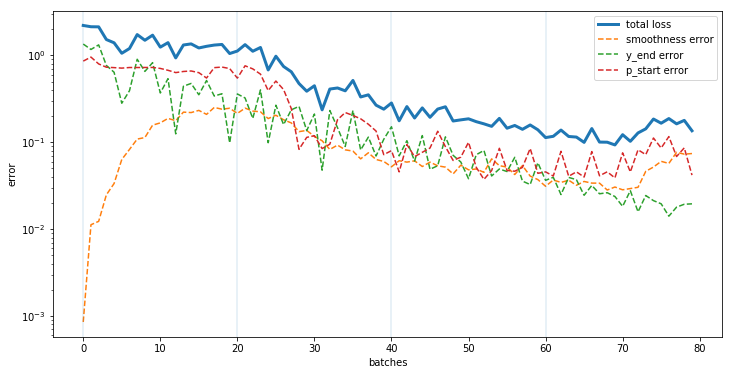

In [26]:
##################################################
#PLOT EVERY LOSS COMPONENT FOR EACH BATCH
timestr = time.strftime("%m%d")
epoch_lines = np.arange(0, epochs*batch, number_of_samples_train)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(smoothness_errors, label = 'smoothness error', linestyle='--')
y_end = plt.plot(y_end_errors, label = 'y_end error', linestyle='--')
p_start = plt.plot(p_start_errors, label = 'p_start error', linestyle='--')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.savefig('Plots/testfig_' + timestr + '.png')
plt.show()

In [9]:
#####################################################
#SAVE MODEL
#Save entire Model
torch.save(model, model_file_path + 'Model_060720_supervised_20k_samples.pt')
torch.save(model, model_file_path + 'Model_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), model_file_path + 'state_dict/Trained_Model_statedict_active_{number_of_samples_train}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = torch.tensor([0.5, 1.1, 0.5])
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_latest.pt')
traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_2x2x2_' + timestr + '.pt')

## Test forward propagation

In [15]:
y_target_test= torch.tensor([0, 2, 0.5])
p = model(y_target_test)
y_pred = Simulate(p)
y_target = y_target_test.detach().numpy()
p = p.detach().numpy()


yTraj_test = dyn.compute(p)

print(yTraj_test.y)
print(np.sum(yTraj_test.y[-3:]-y_target))
print(p)

[ 7.06265214e-05  1.94512096e+00 -2.41065371e-03  3.31315787e-05
  1.92802432e+00 -1.53361098e-03 -2.50241846e-05  1.92932236e+00
  1.56063603e-03 -9.71003644e-05  1.93428661e+00  5.38268862e-03
 -1.62618436e-04  1.93360197e+00  8.86586868e-03 -2.25301555e-04
  1.93395067e+00  1.28316244e-02 -2.85834693e-04  1.93429806e+00
  1.71687823e-02 -3.50448650e-04  1.93525816e+00  2.19732797e-02
 -4.14815980e-04  1.93375367e+00  2.68146188e-02 -4.72172313e-04
  1.93669103e+00  3.27430476e-02 -5.28714245e-04  1.93759710e+00
  3.87745118e-02 -5.78609289e-04  1.93827448e+00  4.51808948e-02
 -6.33160244e-04  1.94006216e+00  5.21617538e-02 -6.88252925e-04
  1.93954718e+00  5.92062964e-02 -7.34688687e-04  1.94146587e+00
  6.70216432e-02 -7.42094754e-04  1.94816654e+00  7.59523267e-02
 -7.49759755e-04  1.95197583e+00  8.48596589e-02 -7.56351785e-04
  1.95427444e+00  9.39290308e-02 -7.62178840e-04  1.95308895e+00
  1.02900194e-01 -7.64573918e-04  1.95149467e+00  1.12150193e-01
 -7.47805104e-04  1.95606